In [1]:
!pip install torch torchvision # add flag --upgrade if not working on GPU
!pip install torch-summary
!pip install opencv-python
!pip install --upgrade --no-cache-dir gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import os

import numpy as np
import pandas as pd
import imageio
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, io
from torchsummary import summary

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import cv2
import pickle
%matplotlib inline

## 1 - Download Cityscapes dataset

In [3]:
!gdown 1ZuT5fGzLwwnHhZ3ANa2Cmsoz9Wy66Io6
!gdown 1yqB8yZTC1v7G9gQ-5OohLcaC5WnEnyH2
!gdown 1oA-gzW7_TF7s7ZGa1d7iXFQ1RFXw1Ihp

!unzip -o gtFine_trainval.zip
!unzip -o leftImg8bit_trainval.zip
!unzip -o checkpoint.zip

Streaming output truncated to the last 5000 lines.
  inflating: gtFine_train_all/strasbourg_000000_014235_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_014416_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_014503_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_014584_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_014743_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_014931_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_015131_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_015506_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_015602_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_015764_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_016024_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_016247_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_016311_gtFine

In [4]:
train_image_folder = '/content/leftImg8bit_train_all'
train_mask_folder = '/content/gtFine_train_all'

val_image_folder = '/content/leftImg8bit_val_all'
val_mask_folder = '/content/gtFine_val_all'

checkpoint_folder = '/content/checkpoint'

## 2 - U-Net model

### 2.1 - Preprocess the data

In [ ]:
class Segmentation_Dataset(Dataset):
    def __init__(self, ImagesDirectory, MasksDirectory):
        self.ImagesDirectory = ImagesDirectory
        self.MasksDirectory = MasksDirectory
        self.images = os.listdir(self.ImagesDirectory)
        self.masks = os.listdir(self.MasksDirectory)

        self.image_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((192, 256), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[0:3])
        ])
        self.mask_transforms = transforms.Compose([
            transforms.Resize((192, 256), interpolation=transforms.InterpolationMode.NEAREST)
        ])

        self.rgb2label = {
            (128, 64, 128): 0,    # road
            (244, 35, 232): 1,    # sidewalk
            (70, 70, 70): 2,      # building
            (102, 102, 156): 3,   # wall
            (190, 153, 153): 4,   # fence
            (153, 153, 153): 5,   # pole
            (250, 170, 30): 6,    # traffic_light
            (220, 220, 0): 7,     # traffic_sign
            (107, 142, 35): 8,    # vegetation
            (152, 251, 152): 9,   # terrain
            (0, 130, 180): 10,    # sky
            (220, 20, 60): 11,    # person
            (255, 0, 0): 12,      # rider
            (0, 0, 142): 13,      # car
            (0, 0, 70): 14,       # truck
            (0, 60, 100): 15,     # bus
            (0, 80, 100): 16,     # train
            (0, 0, 230): 17,      # motorcycle
            (119, 11, 32): 18     # bicycle
        }
        self.ignore_index = 250

    def __len__(self):
        return len(self.images)

    def rgb_to_label(self, mask_rgb):
        h, w, _ = mask_rgb.shape
        label_mask = np.full((h, w), self.ignore_index, dtype=np.uint8)
        for rgb, new_label in self.rgb2label.items():
            match = np.all(mask_rgb[:, :, :3] == np.array(rgb, dtype=np.uint8), axis=-1)
            label_mask[match] = new_label
        return label_mask

    def __getitem__(self, index):
        img_name = self.images[index]

        img_path = os.path.join(self.ImagesDirectory, img_name)
        img = io.read_file(img_path)
        img = io.decode_png(img)  # tensor shape [C, H, W]

        mask_name = img_name.replace("leftImg8bit", "gtFine_color")
        mask_path = os.path.join(self.MasksDirectory, mask_name)

        mask_tensor = io.read_image(mask_path)
        mask_rgb = mask_tensor.permute(1, 2, 0).numpy() # tensor shape [C, H, W]

        label_mask_np = self.rgb_to_label(mask_rgb)
        label_mask = torch.from_numpy(label_mask_np).unsqueeze(0).long() # tensor shape [1, H, W]

        img = self.image_transforms(img)
        label_mask = self.mask_transforms(label_mask)

        return {"IMAGE": img, "MASK": label_mask, "IMG_NAME": img_name}

### 2.2 - Hyperparameters

In [ ]:
EPOCHS = 25
BATCH_SIZE = 32
LR = 0.0001
B1 = 0.9
B2 = 0.999

### 2.3 - Encoder

In [ ]:
class conv_block(nn.Module):
    def __init__(self, in_ch, n_filters=64
    , dropout_prob=0.2, max_pooling=True):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_ch, n_filters, kernel_size=(3, 3), padding=1)
        self.bn = nn.BatchNorm2d(n_filters)
        self.conv_2 = nn.Conv2d(n_filters, n_filters, kernel_size=(3, 3), padding=1)
        self.activation = nn.ReLU()
        self.max_pooling = max_pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) if self.max_pooling else None
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        out = self.conv_1(x)
        out = self.activation(out)
        out = self.bn(out)
        out = self.conv_2(out)
        out = self.activation(out)
        if self.dropout_prob > 0:
          out = self.dropout(out)

        skip_connection = out.clone()
        if self.max_pooling:
          out = self.pool(out)
        next_layer = out
        return next_layer, skip_connection

### 2.4 - Decoder

In [ ]:
class upsampling_block(nn.Module):
    def __init__(self, in_ch, skip_ch, n_filters=64, dropout_prob=0.2):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_ch, in_ch//2, kernel_size=(2, 2), stride=2, padding=0)
        self.dropout = nn.Dropout2d(p=dropout_prob)
        self.conv_1 = nn.Conv2d(in_ch // 2 + skip_ch, n_filters, kernel_size=(3, 3), padding=1)
        self.bn = nn.BatchNorm2d(n_filters)
        self.conv_2 = nn.Conv2d(n_filters, n_filters, kernel_size=(3, 3), padding=1)
        self.activation = nn.ReLU()

    def forward(self, expansive_input, contractive_input):
        conv = self.upsample(expansive_input)
        conv = self.dropout(conv)
        conv = torch.cat([conv, contractive_input], dim=1)
        conv = self.conv_1(conv)
        conv = self.activation(conv)
        conv = self.bn(conv)
        conv = self.conv_2(conv)
        conv = self.activation(conv)
        return conv

### 2.5 - Model construction

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_ch=3, n_filters=64, n_classes=19):
        super().__init__()
        self.conv_layer_1 = conv_block(in_ch, n_filters)
        self.conv_layer_2 = conv_block(n_filters, n_filters*2)
        self.conv_layer_3 = conv_block(n_filters*2,  n_filters*4)
        self.conv_layer_4 = conv_block(n_filters*4, n_filters*8)
        self.conv_layer_5 = conv_block(n_filters*8, n_filters*16, dropout_prob=0, max_pooling=False)

        self.upsample_layer_1 = upsampling_block(n_filters*16, n_filters*8, n_filters * 8)
        self.upsample_layer_2 = upsampling_block(n_filters*8, n_filters*4, n_filters * 4)
        self.upsample_layer_3 = upsampling_block(n_filters*4, n_filters*2, n_filters * 2)
        self.upsample_layer_4 = upsampling_block(n_filters*2, n_filters*1, n_filters * 1)

        self.last_conv = nn.Sequential(
            nn.Conv2d(n_filters, n_filters,  kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_classes,  kernel_size=(1, 1), padding=0),
        )

    def forward(self, x):
        conv_1_next, conv_1_skip = self.conv_layer_1(x)
        conv_2_next, conv_2_skip = self.conv_layer_2(conv_1_next)
        conv_3_next, conv_3_skip = self.conv_layer_3(conv_2_next)
        conv_4_next, conv_4_skip = self.conv_layer_4(conv_3_next)
        conv_5_next, conv_5_skip = self.conv_layer_5(conv_4_next)

        out = self.upsample_layer_1(conv_5_next, conv_4_skip)
        out = self.upsample_layer_2(out, conv_3_skip)
        out = self.upsample_layer_3(out, conv_2_skip)
        out = self.upsample_layer_4(out, conv_1_skip)

        out = self.last_conv(out)
        return out


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet = UNet().to(device)

### 2.6 - Dataset handling

In [ ]:
train_dataloader = DataLoader(Segmentation_Dataset(train_image_folder, train_mask_folder), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(Segmentation_Dataset(val_image_folder, val_mask_folder), batch_size=BATCH_SIZE, shuffle=True)

## 3 - Training and validation

### 3.1 - Metrics computation

In [ ]:
def compute_pixel_accuracy(outputs, targets, ignore_index):
    preds = torch.argmax(outputs, dim=1)
    valid = (targets != ignore_index)
    correct = (preds == targets) & valid
    accuracy = correct.sum().float() / valid.sum().float()
    return accuracy.item()

def compute_mean_iou(outputs, targets, n_classes, ignore_index):
    preds = torch.argmax(outputs, dim=1)
    ious = []
    for cls in range(n_classes):
        pred_mask = (preds == cls)
        target_mask = (targets == cls)
        if target_mask.sum() == 0:
            continue
        intersection = (pred_mask & target_mask).sum().float()
        union = (pred_mask | target_mask).sum().float()
        if union > 0:
            ious.append((intersection / union).item())
    if ious:
        return np.mean(ious)
    else:
        return 0.0

### 3.2 - Training and validation cycle

In [ ]:
metrics_path = os.path.join(checkpoint_folder, 'metrics.pkl')
os.makedirs(checkpoint_folder, exist_ok=True)

if os.path.exists(metrics_path):
    with open(metrics_path, 'rb') as f:
        metrics = pickle.load(f)
    train_losses      = metrics.get('train_losses', [])
    val_losses        = metrics.get('val_losses', [])
    train_accuracies  = metrics.get('train_accuracies', [])
    val_accuracies    = metrics.get('val_accuracies', [])
    train_mean_ious   = metrics.get('train_mean_ious', [])
    val_mean_ious     = metrics.get('val_mean_ious', [])
else:
    train_losses      = []
    val_losses        = []
    train_accuracies  = []
    val_accuracies    = []
    train_mean_ious   = []
    val_mean_ious     = []


checkpoint_path = os.path.join(checkpoint_folder, 'unet_checkpoint.pth')
os.makedirs(checkpoint_folder, exist_ok=True)

criterion = nn.CrossEntropyLoss(ignore_index=250)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR, betas=(B1, B2))
n_classes = 19

start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    unet.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")
else:
    print("No checkpoint found, starting training from scratch")

for epoch in range(start_epoch, EPOCHS):
    ### Training Phase ###
    unet.train()
    epoch_train_loss  = 0.0
    epoch_train_acc   = 0.0
    epoch_train_miou  = 0.0
    train_batches = 0

    for i, batch in enumerate(train_dataloader):
        images = batch['IMAGE'].to(device)
        masks  = batch['MASK'].to(device)
        N, C, H, W = masks.shape
        masks  = masks.reshape((N, H, W)).long()

        optimizer.zero_grad()
        outputs = unet(images)
        loss = criterion(outputs, masks)
        epoch_train_loss += loss.item() * images.size(0)

        with torch.no_grad():
            train_acc  = compute_pixel_accuracy(outputs, masks, ignore_index=250)
            train_miou = compute_mean_iou(outputs, masks, n_classes, ignore_index=250)
        epoch_train_acc  += train_acc
        epoch_train_miou += train_miou
        train_batches   += 1

        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch}, Batch {i}, Loss: {loss.item():.4f}, "
              f"Train Acc: {train_acc:.4f}, Train MIoU: {train_miou:.4f}")

    avg_train_loss = round(epoch_train_loss / len(train_dataloader.dataset), 4)
    avg_train_acc  = round(epoch_train_acc / train_batches, 4)
    avg_train_miou = round(epoch_train_miou / train_batches, 4)

    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    train_mean_ious.append(avg_train_miou)

    ### Validation Phase ###
    unet.eval()
    epoch_val_loss  = 0.0
    epoch_val_acc   = 0.0
    epoch_val_miou  = 0.0
    val_batches = 0

    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            images = batch['IMAGE'].to(device)
            masks  = batch['MASK'].to(device)
            N, C, H, W = masks.shape
            masks  = masks.reshape((N, H, W)).long()

            outputs = unet(images)
            loss = criterion(outputs, masks)
            epoch_val_loss += loss.item() * images.size(0)

            val_acc  = compute_pixel_accuracy(outputs, masks, ignore_index=250)
            val_miou = compute_mean_iou(outputs, masks, n_classes, ignore_index=250)
            epoch_val_acc  += val_acc
            epoch_val_miou += val_miou
            val_batches   += 1

    avg_val_loss = round(epoch_val_loss / len(val_dataloader.dataset), 4)
    avg_val_acc  = round(epoch_val_acc / val_batches, 4)
    avg_val_miou = round(epoch_val_miou / val_batches, 4)

    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    val_mean_ious.append(avg_val_miou)

    print(f"Epoch {epoch} -- "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Train Acc: {avg_train_acc:.4f}, Val Acc: {avg_val_acc:.4f}, "
          f"Train MIoU: {avg_train_miou:.4f}, Val MIoU: {avg_val_miou:.4f}")

    metrics = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_mean_ious': train_mean_ious,
        'val_mean_ious': val_mean_ious,
    }
    with open(metrics_path, 'wb') as f:
        pickle.dump(metrics, f)
    print(f"Metrics saved to {metrics_path}")

    torch.save({
        'epoch': epoch,
        'model_state_dict': unet.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
    }, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch}")

Resuming training from epoch 10
Epoch 10, Batch 0, Loss: 0.3555, Train Acc: 0.8923, Train MIoU: 0.2973
Epoch 10, Batch 1, Loss: 0.3442, Train Acc: 0.8973, Train MIoU: 0.2782
Epoch 10, Batch 2, Loss: 0.2742, Train Acc: 0.9186, Train MIoU: 0.3213
Epoch 10, Batch 3, Loss: 0.4095, Train Acc: 0.8751, Train MIoU: 0.2490
Epoch 10, Batch 4, Loss: 0.3144, Train Acc: 0.9030, Train MIoU: 0.2612
Epoch 10, Batch 5, Loss: 0.3540, Train Acc: 0.8957, Train MIoU: 0.2906
Epoch 10, Batch 6, Loss: 0.2804, Train Acc: 0.9175, Train MIoU: 0.3084
Epoch 10, Batch 7, Loss: 0.3243, Train Acc: 0.8987, Train MIoU: 0.2736
Epoch 10, Batch 8, Loss: 0.3647, Train Acc: 0.8926, Train MIoU: 0.2649
Epoch 10, Batch 9, Loss: 0.3213, Train Acc: 0.9025, Train MIoU: 0.2780
Epoch 10, Batch 10, Loss: 0.3009, Train Acc: 0.9136, Train MIoU: 0.3064
Epoch 10, Batch 11, Loss: 0.3564, Train Acc: 0.8896, Train MIoU: 0.2909
Epoch 10, Batch 12, Loss: 0.3001, Train Acc: 0.9120, Train MIoU: 0.2866
Epoch 10, Batch 13, Loss: 0.3696, Train Ac

## 4 - Visualizing results

### 4.1 - Plotting the metrics

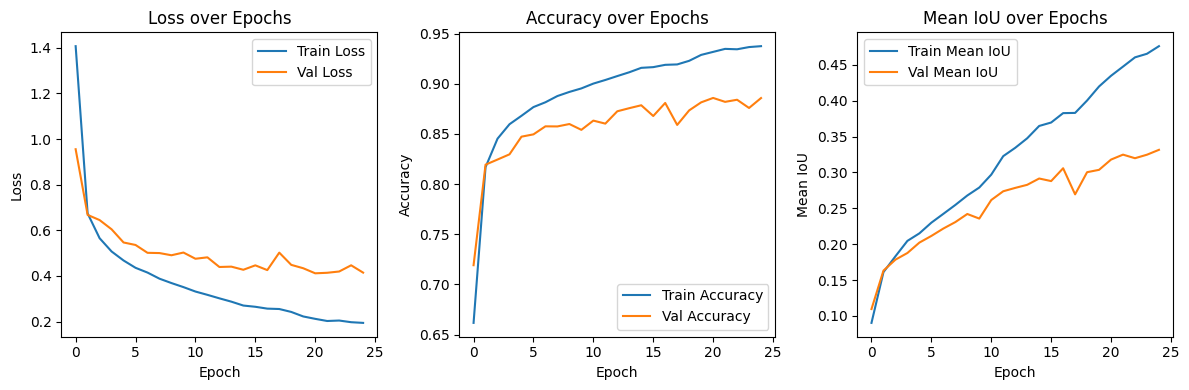

In [ ]:
metrics_path = os.path.join(checkpoint_folder, 'metrics.pkl')

with open(metrics_path, 'rb') as f:
    metrics = pickle.load(f)

epochs = range(len(metrics['train_losses']))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, metrics['train_losses'], label='Train Loss')
plt.plot(epochs, metrics['val_losses'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, metrics['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, metrics['val_accuracies'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, metrics['train_mean_ious'], label='Train Mean IoU')
plt.plot(epochs, metrics['val_mean_ious'], label='Val Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.title('Mean IoU over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### 4.2 - Plotting the predictions

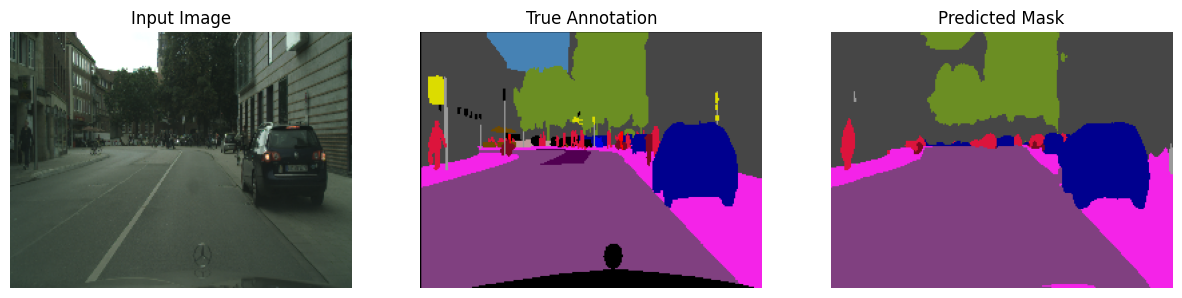

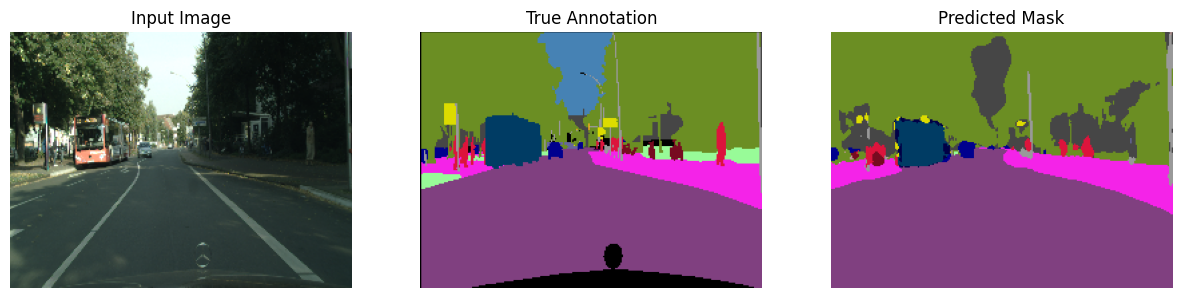

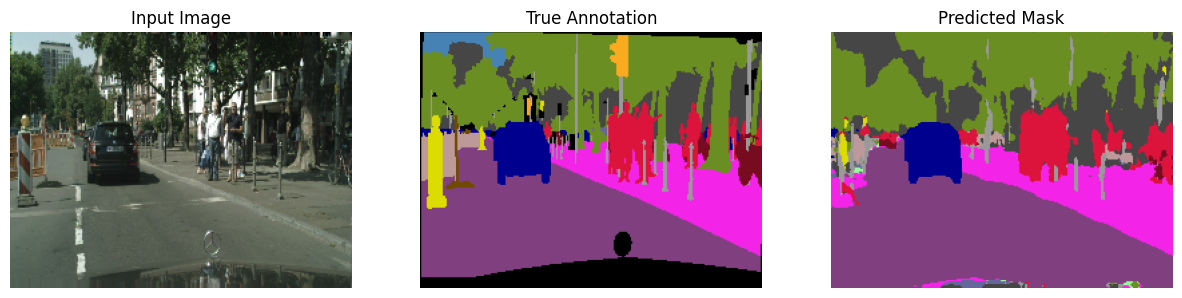

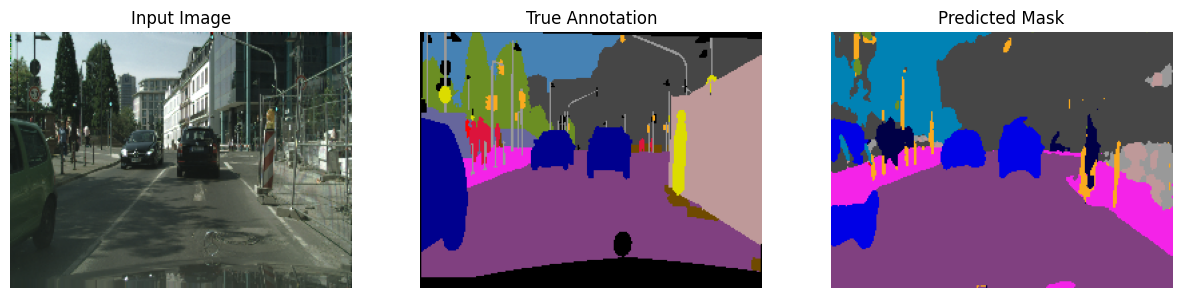

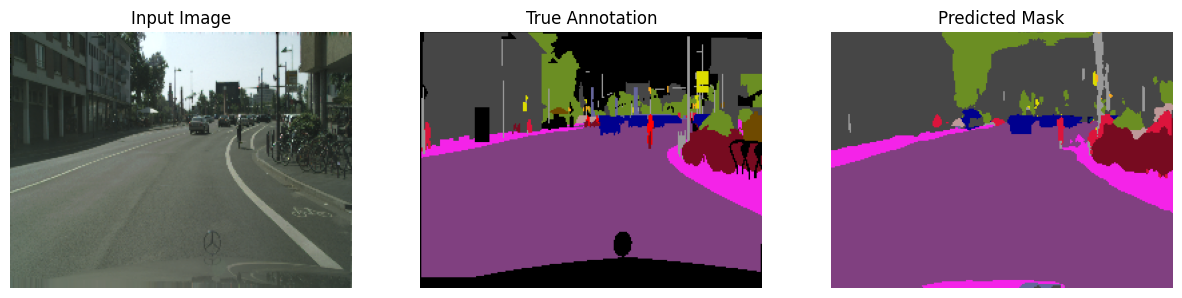

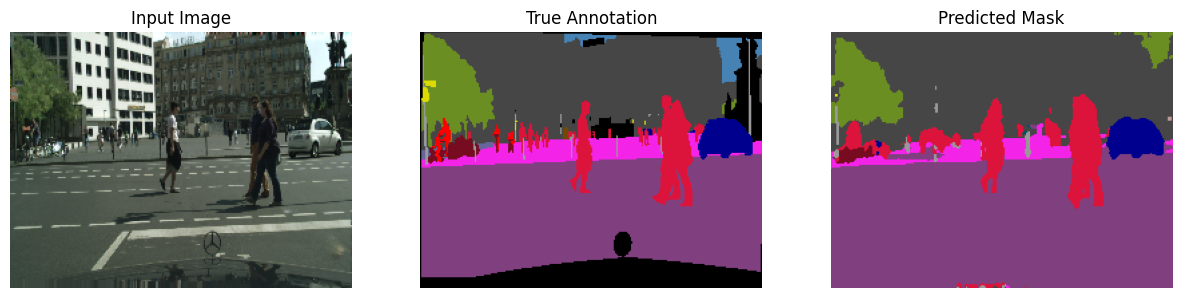

In [ ]:
def get_cityscapes_cmap():
    colors = np.array([
        [128, 64, 128],   # road
        [244, 35, 232],   # sidewalk
        [70, 70, 70],     # building
        [102, 102, 156],  # wall
        [190, 153, 153],  # fence
        [153, 153, 153],  # pole
        [250, 170, 30],   # traffic light
        [220, 220, 0],    # traffic sign
        [107, 142, 35],   # vegetation
        [152, 251, 152],  # terrain
        [0, 130, 180],    # sky
        [220, 20, 60],    # person
        [255, 0, 0],      # rider
        [0, 0, 142],      # car
        [0, 0, 70],       # truck
        [0, 60, 100],     # bus
        [0, 80, 100],     # train
        [0, 0, 230],      # motorcycle
        [119, 11, 32]     # bicycle
    ], dtype=np.float32) / 255.0
    return ListedColormap(colors)

def create_mask(pred_mask):
    pred = torch.argmax(pred_mask, dim=1, keepdim=True)
    return pred

def show_predictions(dataloader, device, num=1):
    unet.eval()
    custom_cmap = get_cityscapes_cmap()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            img = batch["IMAGE"][0].to(device).unsqueeze(0)

            img_name = batch["IMG_NAME"][0]
            true_mask_name = img_name.replace("leftImg8bit", "gtFine_color")
            true_mask_path = os.path.join("gtFine_val_all", true_mask_name)

            true_mask_color = cv2.imread(true_mask_path)
            if true_mask_color is None:
                print(f"Could not load true annotation at: {true_mask_path}; skipping sample.")
                continue
            true_mask_color = cv2.cvtColor(true_mask_color, cv2.COLOR_BGR2RGB)
            true_mask_color = cv2.resize(true_mask_color, (256, 192), interpolation=cv2.INTER_NEAREST)

            output = unet(img)
            pred_mask = create_mask(output)

            img_disp = img[0].cpu().permute(1, 2, 0)
            pred_mask_disp = pred_mask[0].cpu().squeeze(0)

            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(img_disp)
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(true_mask_color)
            plt.title("True Annotation")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask_disp, cmap=custom_cmap)
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.show()

            if i >= num - 1:
                break

show_predictions(val_dataloader, device, num=6)